<a href="https://colab.research.google.com/github/andygoosh/OneTwoTrip-Contest/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
if '0.22' != sklearn.__version__:
  !pip install -U scikit-learn

print(sklearn.__version__)
assert ('0.22' == sklearn.__version__)

0.22


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
import tensorflow.keras as keras

print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)
assert ('0.22' == sklearn.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

TensorFlow 2.x selected.
Populating the interactive namespace from numpy and matplotlib
2.0.0
2.2.4-tf
0.22


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


RandomState(MT19937) at 0x7F7F1C6D7780

In [3]:
df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid', dtype={'field1': np.float32, 'field14': np.float32})
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid', dtype={'field1': np.float32, 'field14': np.float32})

df_train

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704080,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196051,e33b0b1abb0038261ea9fb5213b9aad000a7686edab9e4...,30,-0.083509,7,7,2,0,0,2,1,0,1,0,91,511,0.459223,1,4,33,7,2,3,1,1,17,1,1,3,1,0,3,1,1,0,1,0,0,0,0,0,0,0
196052,ed64c2d35a57e9e8e8e5bc84f3addf5552e1691a52a75d...,104,-0.548937,11,11,2,0,0,1,1,0,0,8,5,16,-0.521242,1,0,1,5,2,5,1,1,23,1,1,12,3,0,4,1,1,0,0,0,0,0,0,0,0,0
196053,b74f63aae0b4a21b972a8a322f36e7935dbd44fe47762e...,12,0.692205,9,9,3,0,0,2,1,0,1,12,2,12,-0.101043,3,7,3,5,2,5,1,1,2,3,1,12,3,0,3,1,1,1,1,1,0,0,0,0,0,0


In [4]:
df_train.describe()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
count,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000
mean,28.413163,0.000912,7.980363,7.867864,3.528966,0.556214,1.577911,1.265292,0.879366,0.023937,0.448117,14.633431,12.010492,27.046028,0.001822,1.517153,15.723854,3.001301,3.811941,2.076172,3.993762,1.226471,38.751938,13.028186,1.404645,4.923456,3.875780,1.746557,0.088572,2.980837,0.994966,0.979649,0.348676,0.645754,0.647687,0.036627,0.168579,0.038713,0.022519,0.015098,0.022142
std,69.603944,1.009402,2.757008,3.013659,12.692057,0.496831,5.614900,0.441489,0.325702,0.164366,0.497302,5.519693,19.579464,55.490962,1.007440,0.952774,25.689926,8.510708,1.931365,0.980940,1.975246,0.418548,71.517212,6.132370,0.784647,11.652149,4.230396,1.376456,0.369773,0.919229,0.070774,0.141199,0.476552,0.478285,0.477692,0.187845,0.374381,0.192912,0.148365,0.121942,0.147144
min,0.000000,-0.859222,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.941441,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.471365,6.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,11.000000,4.000000,3.000000,-0.521242,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.238651,8.000000,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,15.000000,5.000000,4.000000,-0.241109,1.000000,6.000000,1.000000,4.000000,2.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.000000,0.149205,10.000000,10.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,19.000000,11.000000,26.000000,0.179090,2.000000,18.000000,1.000000,5.000000,3.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,500.000000,82.142136,12.000000,12.000000,363.000000,1.000000,323.000000,2.000000,1.000000,4.000000,1.000000,23.000000,273.000000,746.000000,55.225182,18.000000,340.000000,156.000000,7.000000,8.000000,7.000000,2.000000,867.000000,23.000000,18.000000,170.000000,28.000000,7.000000,8.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a.field0.max()


363

In [0]:
def vectorize( X, cols ):

  for col in cols:
    df = pd.get_dummies(X[col])
    df.columns = ['%s_%d' % (col, i) for i in range(df.shape[1])]
    X = X.join(df)
  X.drop(cols, axis=1, inplace=True)

  return X

In [0]:
def prepare_data( data, undersample=0):
  # filed4 - order count
  X = data.copy()
  y = []

  # undersampling
  if undersample > 0:
    # Separate majority and minority classes
    df_majority = X[X['goal1']==0]
    df_minority = X[X['goal1']==1]
    
    n_samples = math.floor( X['goal1'].sum() * undersample )

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=n_samples,     # to match minority class
                                    random_state=RS) # reproducible results
    
    # Combine minority class with downsampled majority class
    X = pd.concat([df_majority_downsampled, df_minority])# Separate majority and minority classes

  # separate the target
  if  'goal1' in X.columns:
    y = X[['goal1']].astype(int)

  FTS = list(filter(lambda x: 'field' in x, X.columns))
  X = X[FTS]
  '''
  # add polimonial
  X['field7_field16'] = X['field7'] * X['field16']
  X['field16_field17'] = X['field16'] * X['field17']
  #X['field16_field25'] = X['field16'] * X['field25']
  X['field12_field16'] = X['field12'] * X['field16']
  X['field7_field12'] = X['field7'] * X['field12']
  X['field12_field25'] = X['field12'] * X['field25']
  
  # drop unimportant or negatively impacting
  X.drop(['field0', 'field29', 'field28'], axis=1, inplace=True)

  X = vectorize(X, ['field21']) #, 'field5', 'field7', 'field8', 'field9', 'field10', 'field18', 'field19', 'field20', 'field27'])
  X.drop(['field21_1'], axis=1, inplace=True)
  '''
  #X['userid'] = data['userid']

  #enc1 = skl.preprocessing.LabelEncoder().fit(X['field1'].values.reshape(-1, 1))
  #X['field1'] = enc1.transform(X['field1'].values.reshape(-1, 1)).flatten()
  #enc14 = skl.preprocessing.LabelEncoder().fit(X['field14'].values.reshape(-1, 1))
  #X['field14'] = enc14.transform(X['field14'].values.reshape(-1, 1)).flatten()

  return X, y

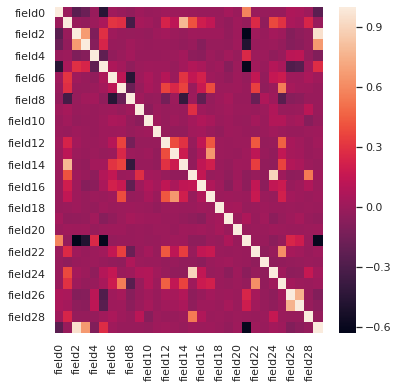

In [7]:
import seaborn as sns; sns.set()
X, y = prepare_data(df_train)
ax = sns.heatmap(X.corr())

In [8]:
corr = df_train.corr()
corr.field2['field29'], corr.field15['field24']

(0.9539990460663368, 0.8997383624774794)

In [0]:
def add_polynomial_inner( X, poly ):
  X = X
  X = pd.DataFrame(poly.transform(X), index=X.index, columns = poly.get_feature_names(X.columns))
  return X
    
def add_polynomial(X_train, X_cv=None, degree=2):
  poly = sklearn.preprocessing.PolynomialFeatures(degree)
  poly.fit(X)
  
  X_train = add_polynomial_inner(X_train, poly)
  if X_cv is not None:
      X_cv = add_polynomial_inner(X_cv, poly)

  #poly_corrs = poly_features.corrwith(y).sort_values(ascending=False)
  #poly_corrs = poly_features.corrwith(y).nlargest(20)

  return X_train, X_cv, poly

In [0]:
def add_neughbors_inner( X, neigh ):
    X = X.copy()
    dists, _ = neigh.kneighbors(X, return_distance=True)
    X['K-mean'] = dists.mean(axis=1).reshape(-1, 1)
    X['K-max'] = dists.max(axis=1).reshape(-1, 1)
    return X

def add_neighbors(X_train, X_cv=None, n_neighbors=5):
  neigh = skl.neighbors.NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
  neigh.fit(X_train)

  X_train = add_neughbors_inner(X_train, neigh)
  if X_cv is not None:
      X_cv = add_neughbors_inner(X_cv, neigh)

  return X_train, X_cv, neigh

44.16378714581894
(196056, 30)


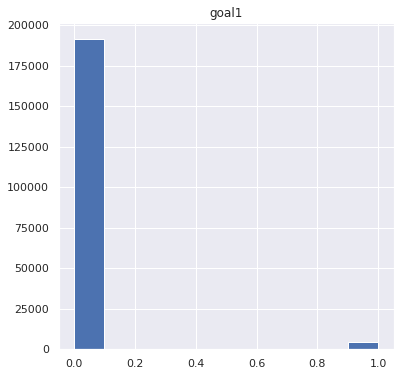

In [11]:
X, y = prepare_data( df_train )
y.hist()
print(np.unique(y, return_counts=True)[1][0]/np.unique(y, return_counts=True)[1][1])
print(X.shape)

In [0]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y.iloc[train_idx], y.iloc[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()
    model.fit(X_train, y_train.values.ravel(), 
              #eval_set = [(X_cv, y_cv.values.ravel())],
              #verbose=0,
              #early_stopping_rounds = 100,
              )
    plot_cm_and_roc(model, X_cv, y_cv, 'cv')

    y_pred_cv = model.predict_proba(X_cv)
    # score = skl.metrics.roc_auc_score(keras.utils.to_categorical(y_cv), y_pred_cv) # works for multiclass
    score = skl.metrics.roc_auc_score(y_cv, y_pred_cv[:, 1]) # better one for binary
    scores.append(score)
    models.append(model)
    #print('[{:}/{:}>{:.5f}]'.format(j+1,n_folds, score) , end='')


  print('{:} cv: {:.4f} ± {:.4f}.'.format(type(model).__name__, np.mean(scores), np.std(scores)))
  return scores, models, neighbs, polies

In [0]:
def plot_permutation_importance(model, X_test, y_test, X_cv=None, y_cv=None):
  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (15,5)

  result = permutation_importance(model, X_test, y_test.values.ravel(), n_repeats=10, random_state=RS)
  sorted_idx = result.importances_mean.argsort()

  if  X_cv is None:
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax1.set_title("Test Permutation Importance of each feature")
    ax1.set_ylabel("Features")

    result = permutation_importance(model, X_cv, y_cv.values.ravel(), n_repeats=10, random_state=RS)
    sorted_idx = result.importances_mean.argsort()

    ax2.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax2.set_title("CV Permutation Importance of each feature")
    ax2.set_ylabel("Features")

    fig.tight_layout()

  plt.show()
  plt.rcParams["figure.figsize"] = old_rcparam


In [0]:
def plot_cm_and_roc(model, X, y, title=''):
  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (15,4)

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  fig.suptitle('{} {}'.format(type(model).__name__, title))
  skl.metrics.plot_confusion_matrix(model, X, y, ax=ax1)
  skl.metrics.plot_roc_curve(model, X, y, ax=ax2)

  plt.show()
  plt.rcParams["figure.figsize"] = old_rcparam

In [0]:
def add_aggregates(X):
  # add aggregates for userid
  AGGREGATES = [] #'std', 'sum', 'max', 'min', 'mean'
  grouped_by = X.groupby('userid')
  all_features = []
  
  if len(AGGREGATES) > 0:
    FTS = list(filter(lambda x: 'field' in x, X.columns))
    for col in FTS:
      grouped = grouped_by.agg({col: AGGREGATES}) 
      grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
      all_features.append(grouped)

  # add count
  grouped = grouped_by.agg({'userid': 'count'})
  grouped.columns = ['ord_cnt']
  all_features.append( grouped )

  if len(all_features)>0:
    all_features = pd.concat(all_features, axis=1)
    X = X.merge(all_features, on=('userid'))

  return X.drop(['userid'], axis=1)


In [0]:
def to_buckets(X, bins):
  return pd.cut(X, bins, labels=False)

In [0]:
def estimate(X, y, model):
  X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)
  
  # apply class weights
  class_weights = list(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.values.ravel()))
  w_array = pd.Series(np.ones(y_train.shape[0], dtype = 'float32'), index=y_train.index)\
                    .apply(lambda x: class_weights[0] if x==0 else class_weights[1])
  
  #try:
  #  sklearn.utils.validation.check_is_fitted(model, type(model).__name__, 'Model is not fitted')
  #except sklearn.utils.validation.NotFittedError:
  if type(model).__name__ == 'XGBClassifier':
    print(0)
    model.fit(X_train, y_train.values.ravel(), 
              eval_set=[(X_cv, y_cv)],
              #early_stopping_rounds=100,
              #sample_weight=w_array
              )
  else:
    print(1)
    model.fit(X_train, y_train.values.ravel(), 
              #sample_weight=w_array
              )

  plot_cm_and_roc(model, X_train, y_train, 'train')
  plot_cm_and_roc(model, X_cv, y_cv, 'cv')

  return model

In [18]:
e = skl.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.values.ravel())
e

array([ 0.51132149, 22.58189357])

In [19]:
counts = np.unique(y, return_counts=True)[1]
counts[0]/counts[1]

44.16378714581894

In [0]:
def get_best_params():
  estimators = 298
  return {'base_score': 0.9883241431311958, 
  'booster': 'gbtree',
  'colsample_bylevel': 0.8954745282201794, 
  'colsample_bynode': 0.9053728787963939, 
  'colsample_bytree': 0.37737648074076036, 
  'gamma': 51, 
  'learning_rate': 0.06869149756603576, 
  'max_delta_step': 22, 
  'max_depth': 4, 
  'min_child_weight': 0.8940873051252118, 
  'missing': None,
  'n_estimators': estimators, 
  'n_jobs': -1,
  'nthread': None,
  'objective': 'binary:logistic',
  'random_state': RS,
  'reg_alpha': 0.2901487558842103, 
  'reg_lambda': 0.7240220329478356, 
  'scale_pos_weight': 0.11997115325466545,  #0.04082
  'seed': None,
  'silent': None,
  'subsample': 0.699092108437742,
  'verbosity': 0,
  # If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping
  'eval_metric': ['logloss', 'auc'],
  # 'rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-'
  'tree_method': 'gpu_hist',
  'updater': 'grow_gpu_hist',
  'disable_default_eval_metric': 0,
  } # 0.6827676748753305


0
[0]	validation_0-logloss:2.91506	validation_0-auc:0.5
[1]	validation_0-logloss:1.73227	validation_0-auc:0.5
[2]	validation_0-logloss:1.42119	validation_0-auc:0.5


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-logloss:1.21309	validation_0-auc:0.5
[4]	validation_0-logloss:1.05783	validation_0-auc:0.5
[5]	validation_0-logloss:0.935346	validation_0-auc:0.5
[6]	validation_0-logloss:0.835328	validation_0-auc:0.5
[7]	validation_0-logloss:0.751703	validation_0-auc:0.5
[8]	validation_0-logloss:0.680574	validation_0-auc:0.5
[9]	validation_0-logloss:0.619283	validation_0-auc:0.5
[10]	validation_0-logloss:0.565928	validation_0-auc:0.5
[11]	validation_0-logloss:0.519102	validation_0-auc:0.5
[12]	validation_0-logloss:0.477733	validation_0-auc:0.5
[13]	validation_0-logloss:0.440983	validation_0-auc:0.5
[14]	validation_0-logloss:0.408188	validation_0-auc:0.5
[15]	validation_0-logloss:0.37881	validation_0-auc:0.5
[16]	validation_0-logloss:0.352408	validation_0-auc:0.5
[17]	validation_0-logloss:0.328614	validation_0-auc:0.5
[18]	validation_0-logloss:0.307121	validation_0-auc:0.5
[19]	validation_0-logloss:0.287669	validation_0-auc:0.5
[20]	validation_0-logloss:0.270035	validation_0-auc:0.5
[2

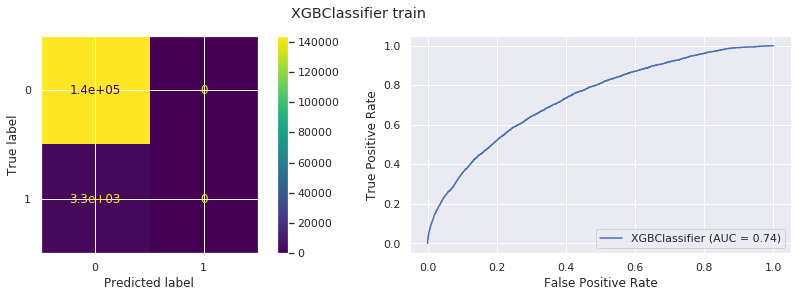

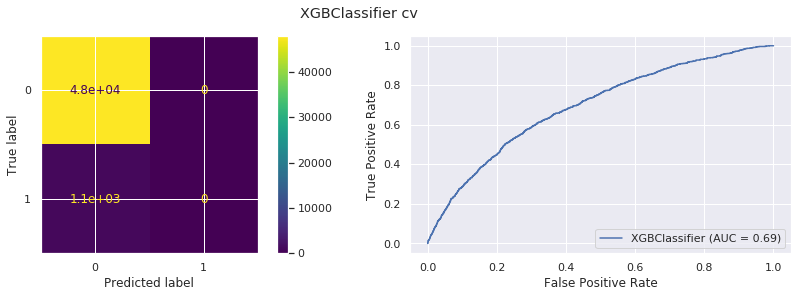

In [30]:
#a = df_train.groupby('userid', as_index=False).count()
#a = a[a.field0 > 1]
#a = df_train.loc[df_train.userid.isin([*a.userid])]

X, y = prepare_data( df_train)

#hgbc = skl.ensemble.HistGradientBoostingClassifier()
xgbc = XGBClassifier(**get_best_params())
clfbag = skl.ensemble.BaggingClassifier(xgbc, n_estimators=10, random_state=RS, oob_score=True)
clf_sigmoid = CalibratedClassifierCV(xgbc, cv=5, method='sigmoid')
#clf_sigmoid1 = CalibratedClassifierCV(clf_sigmoid, cv=5, method='sigmoid') #sigmoid

#vc = skl.ensemble.VotingClassifier(estimators=[('xgb', xgb), ('clf_sigmoid', clf_sigmoid), ('clf_sigmoid1', clf_sigmoid1)], voting='soft')
#vc1 = skl.ensemble.VotingClassifier(estimators=[('lgbm', lgbm), ('lgbm_b', lgbm_b)], weights=[3, 3], voting='soft')

#try:
model = estimate(X, y, xgbc)
#except:
#  pass

if hasattr(model, 'best_ntree_limit'):
  print(model.best_ntree_limit)
  #ypred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

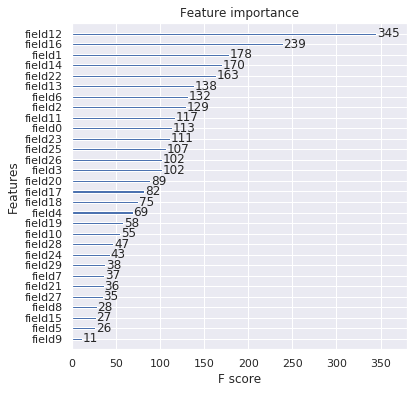

In [31]:
xgb.plot_importance(model)
#xgb.plot_tree(model, num_trees=10)

In [0]:
X, y = prepare_data( df_train)

from sklearn.utils import all_estimators

def_params = {
    'random_state': RS,
    'n_jobs': -1
}

estimators = all_estimators(type_filter='classifier')
for name, class_ in estimators:
  print(class_)
  #try:
  #  model = estimate(X, y, class_());
  #except:
  #  pass


## SequentialFeatureSelector

In [94]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X, y = prepare_data( df_train )

sfs1 = SFS(XGBClassifier(**get_best_params()), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='logloss', 
           #scoring='roc_auc', 
           cv=3,
           n_jobs=-1)

sfs1 = sfs1.fit(X, y.values.ravel())

print(sfs1.k_score_)
print(sfs1.k_feature_names_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished

[2019-12-09 12:49:48] Features: 1/30 -- score: 0.6235264130352441[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:  1.9min finished

[2019-12-09 12:51:41] Features: 2/30 -- score: 0.6668349418907691[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  2.0min finished

[2019-12-09 12:53:39] Features: 3/30 -- score: 0.6716442792651014[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.0min finished

[2019-12-09 12:55:41] Features: 4/30 -- score: 0.6744459122393239[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.9min finished



0.6886620046050345
('field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field12', 'field13', 'field14', 'field16', 'field17', 'field18', 'field19', 'field21', 'field22', 'field25', 'field26', 'field27', 'field28', 'field29')


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.9s finished

[2019-12-09 13:24:54] Features: 30/30 -- score: 0.6858644954669435

## 5-KFold estimation

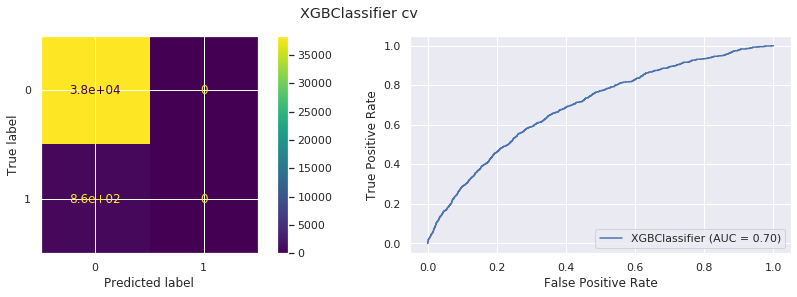

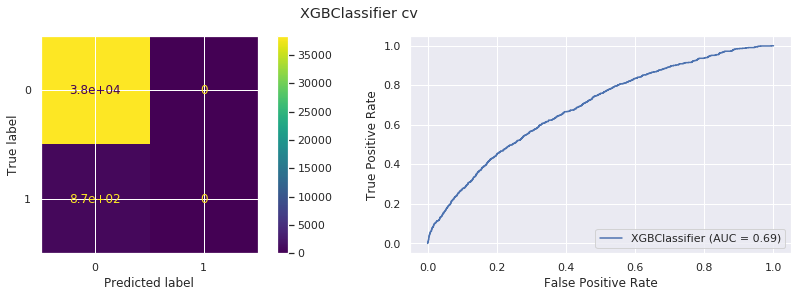

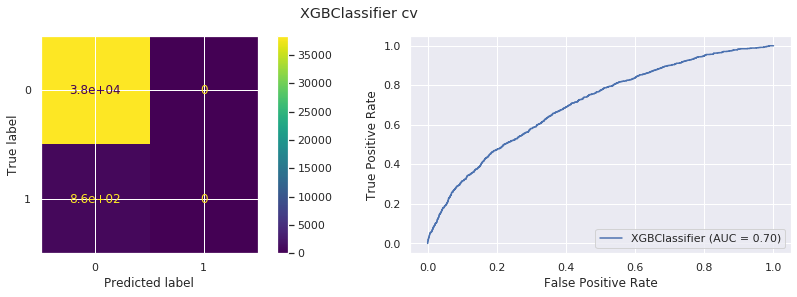

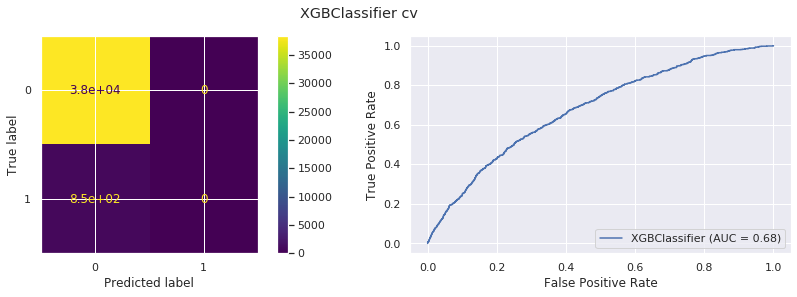

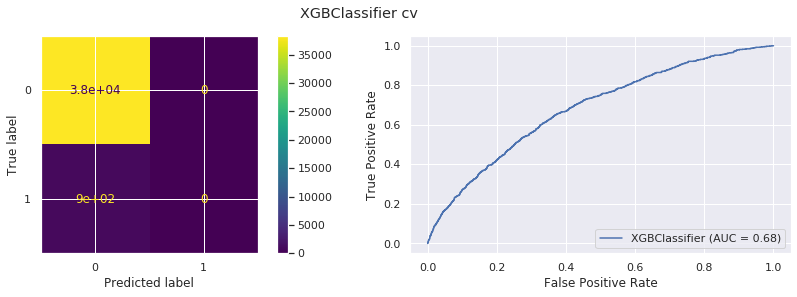

XGBClassifier cv: 0.6907 ± 0.0085.


'\npoly = polies[np.argmax(scores)]\nX = add_polynomial_inner(X, poly)\n'

In [32]:
X, y = prepare_data( df_train )

scores, models, neighbs, polies = fit_estimate(X, y,
        #lambda: skl.ensemble.BaggingClassifier(XGBClassifier(**get_best_params()), n_estimators=10, random_state=RS, oob_score=True),
        lambda: XGBClassifier(**get_best_params()), 
        n_folds=5, degree=0, n_neighbors=0)
model = models[np.argmax(scores)]

'''
neigh = neighbs[np.argmax(scores)]
X = add_neughbors_inner(X, neigh)
'''
'''
poly = polies[np.argmax(scores)]
X = add_polynomial_inner(X, poly)
'''
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier CV: 0.6876 ± 0.0086. params fine tuning, -f0
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier CV: 0.6881 ± 0.0090. params fine tuning, -f0, f28 +5 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6885 ± 0.0078. polinomial, 0 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6895 ± 0.0111. polimonial, 5 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6895 ± 0.0092. -1/2 field21, 0 neigh
# XGBClassifier cv: 0.6907 ± 0.0085. 0 neigh, 

In [120]:
X['count'].sum(), X.shape[0]

(1187694, 196056)

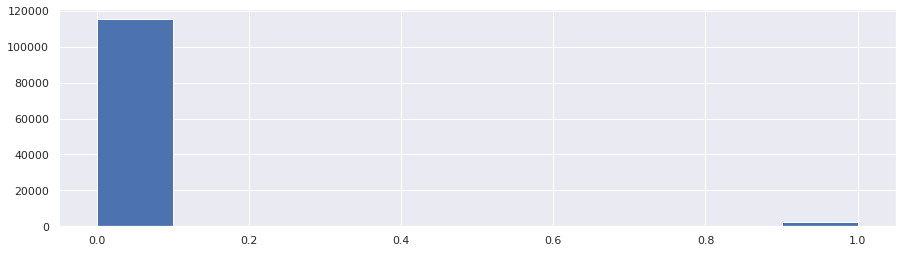

In [124]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a = df_train.loc[df_train.userid.isin([*a.userid])]
a.goal1.hist()

Index(['field16', 'field12', 'field10', 'field7', 'field6', 'field14',
       'field25', 'field21', 'field1', 'field19', 'field0', 'field28',
       'field17', 'field22', 'field18', 'field15', 'field2', 'field29',
       'field13', 'field26', 'field27', 'field9', 'field11', 'field24',
       'field8', 'field23', 'field4', 'field3', 'field20', 'field5'],
      dtype='object')


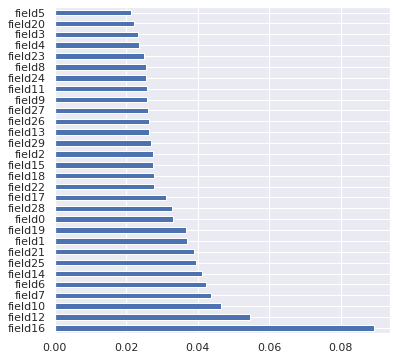

In [34]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
print(feat_importances.nlargest(30).index)

In [87]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
17,field7_field16,0.224827
22,field21_0,0.115388
34,field10_0,0.101748
19,field12_field16,0.088139
21,field12_field25,0.080946
...,...,...
35,field10_1,0.000000
32,field9_3,0.000000
51,field19_8,0.000000
50,field19_7,0.000000


In [0]:
import shap
%time shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

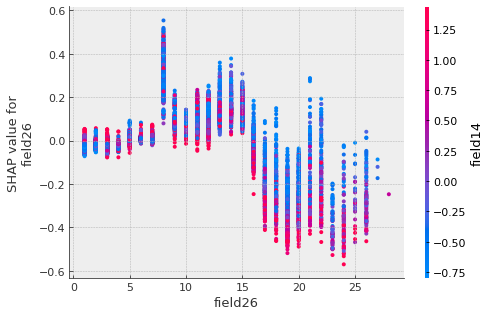

In [91]:
shap.dependence_plot("field26", shap_values, X)

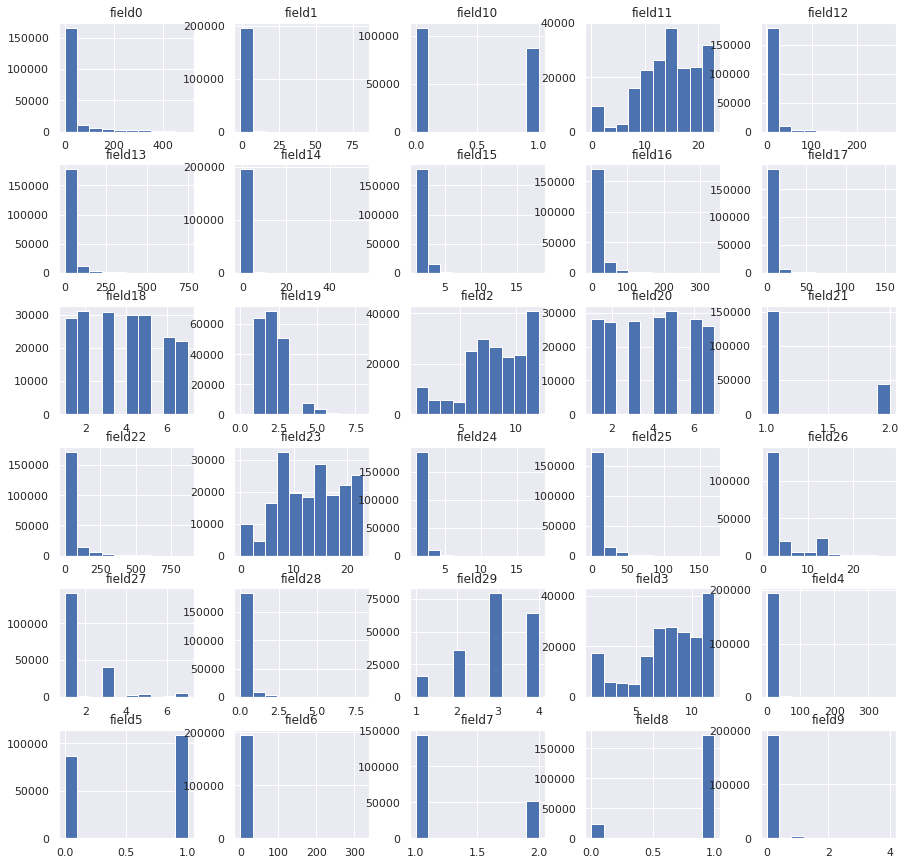

In [36]:
old_rcparam = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,15)

X.hist()

plt.rcParams["figure.figsize"] = old_rcparam


In [0]:
from sklearn.manifold import TSNE

plt_data = X.head(10000)

tsne = TSNE(random_state=0)
tsne_rep = tsne.fit_transform(plt_data)

#plt.scatter(tsne_rep[:,0], tsne_rep[:,1], c=plt_data['target'].map({0:'blue', 1:'red'}), alpha=.5)
plt.scatter(tsne_rep[y==0,0], tsne_rep[y==0,1], alpha=.5, c='blue', label='norm')
plt.scatter(tsne_rep[y==1,0], tsne_rep[y==1,1], alpha=.5, c='orange', label='refunded')
plt.legend()

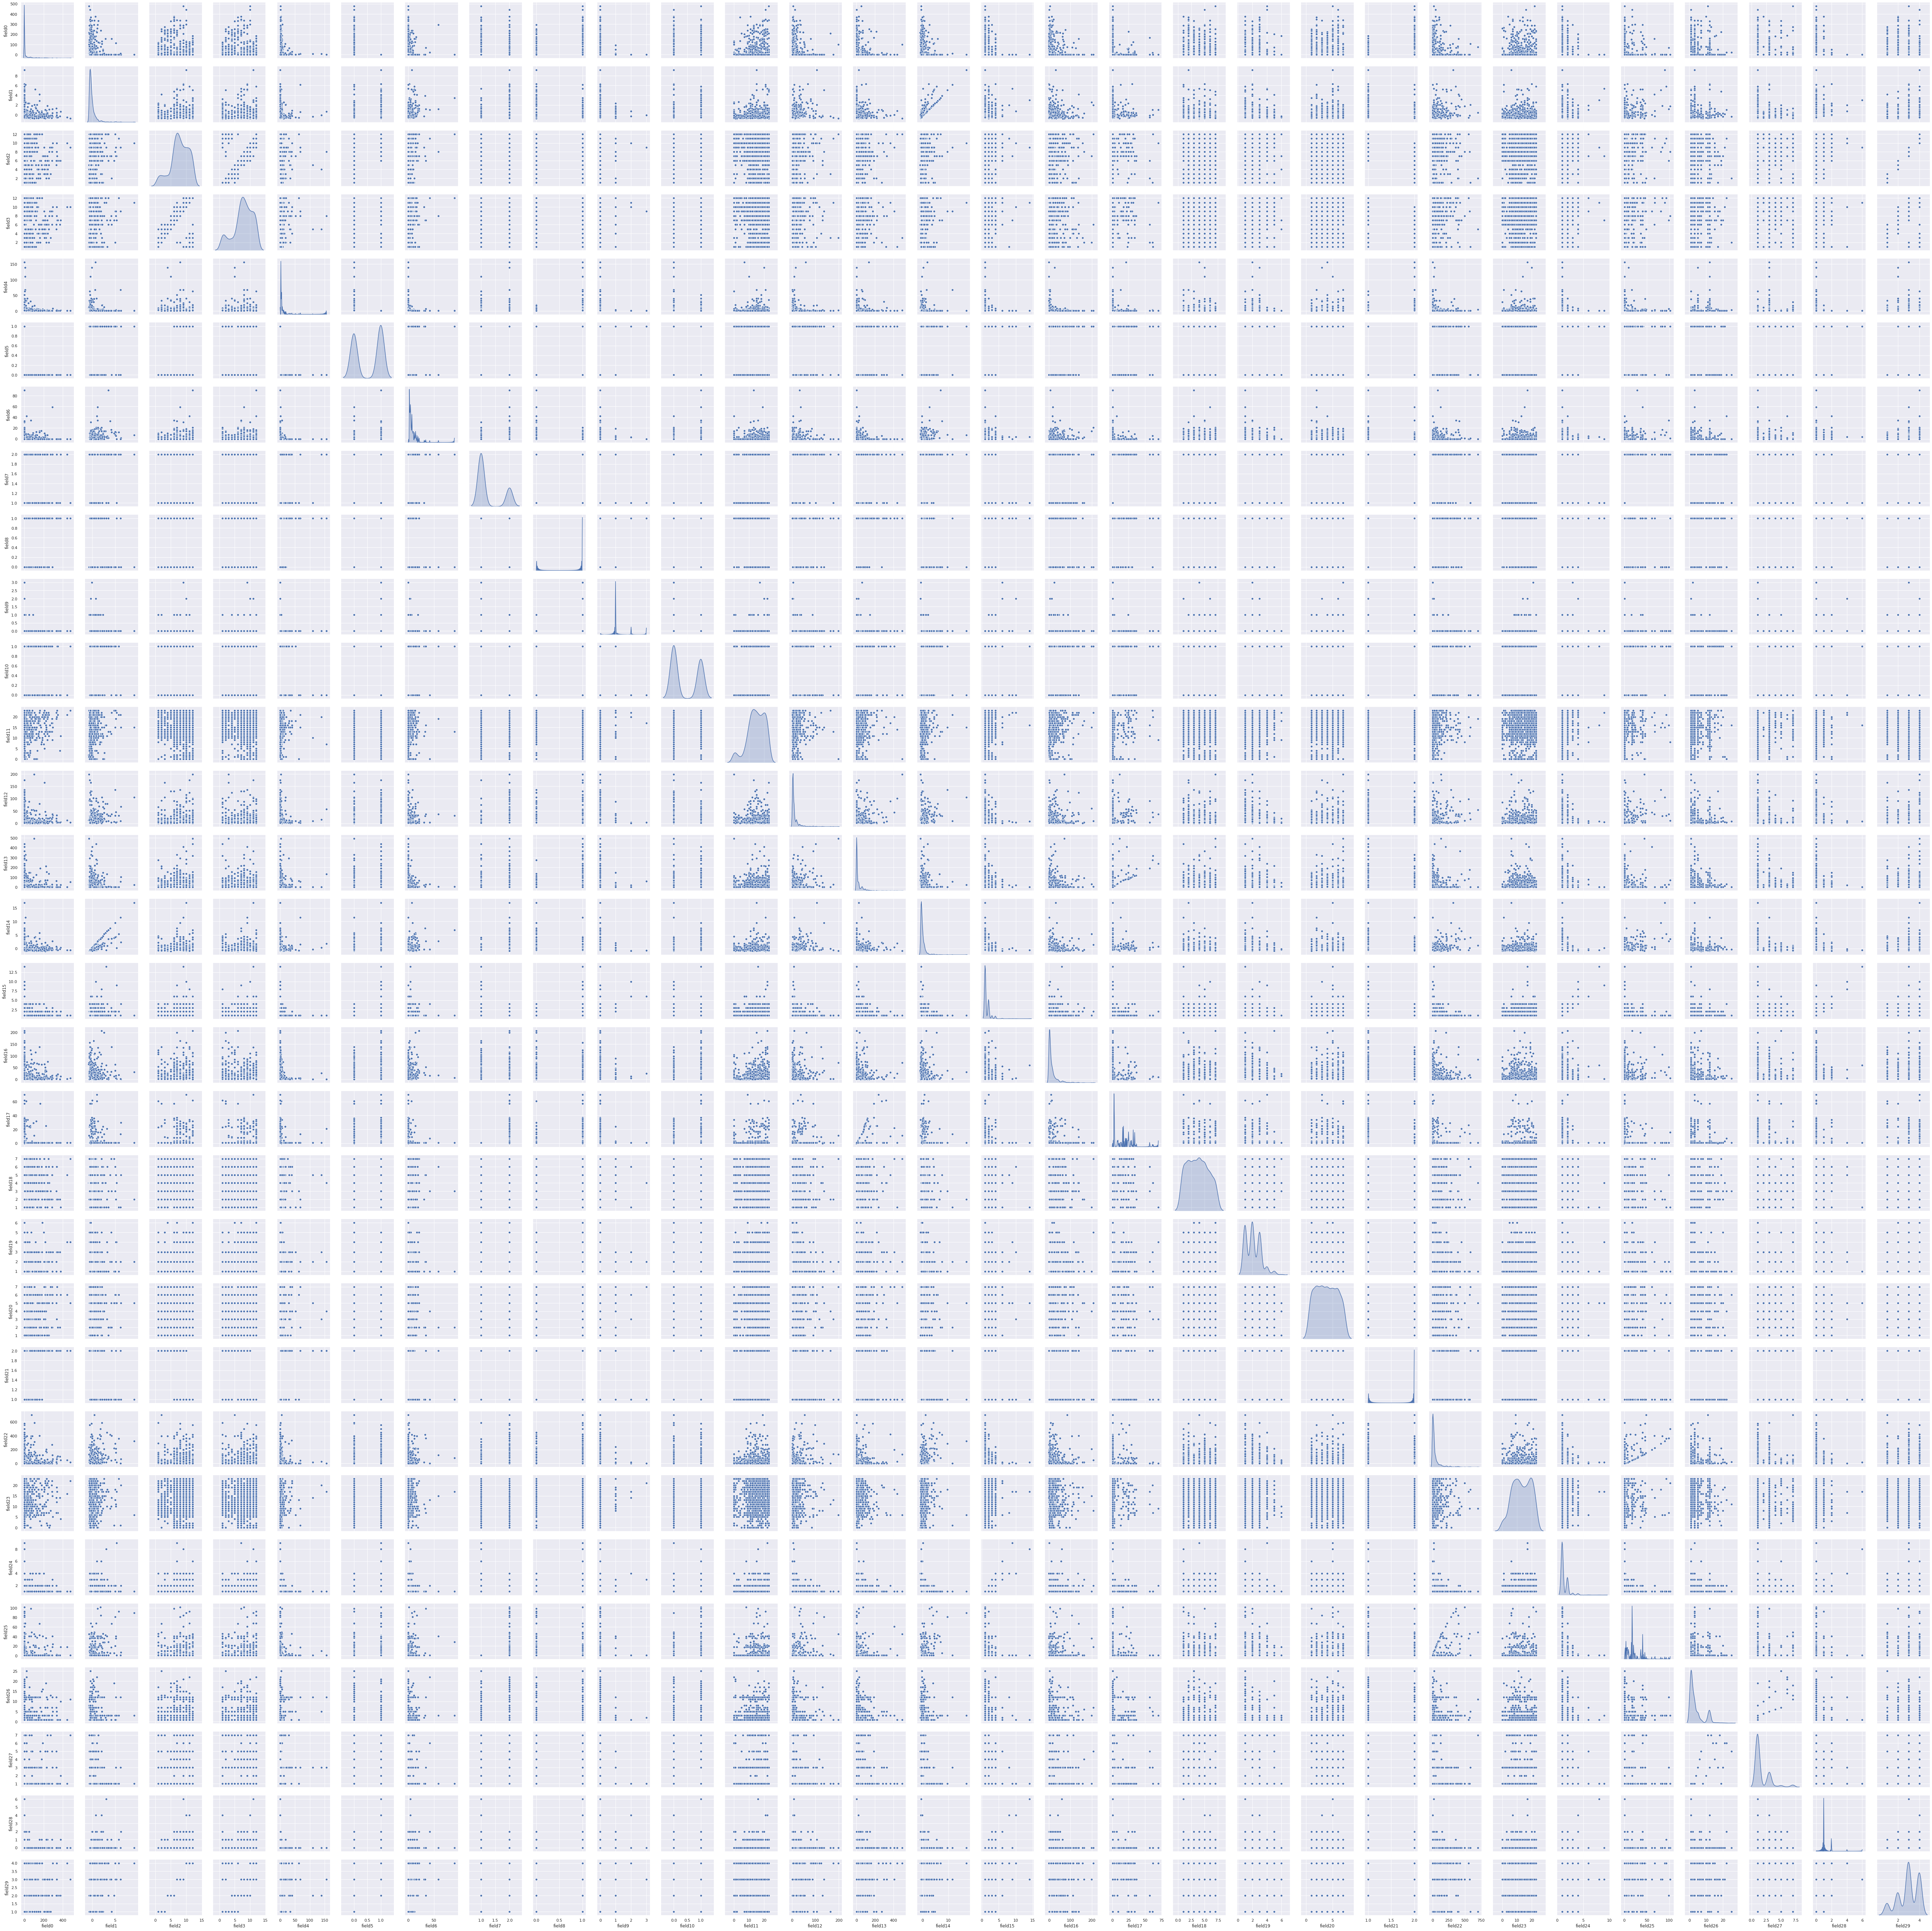

In [39]:
import seaborn as sns

sns.pairplot(X_train.head(1000), diag_kind="kde")

## SearchGridCV

In [101]:
X, y = prepare_data( df_train )

parameters_xgb = { 
  'eval_metric': ['rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 
                  'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 
                  'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-']

  }

gs = GridSearchCV(XGBClassifier(**get_best_params()), 
                  parameters_xgb, 
                  cv=KFold( n_splits = 5, shuffle=True, random_state=RS),
                  verbose=10, 
                  n_jobs=-1,
                  scoring='neg_log_loss') #'roc_auc')
gs.fit(X, y)
print( gs.best_params_ )
print( gs.best_score_ )

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

{'eval_metric': 'rmse'}
-0.12814730871446717


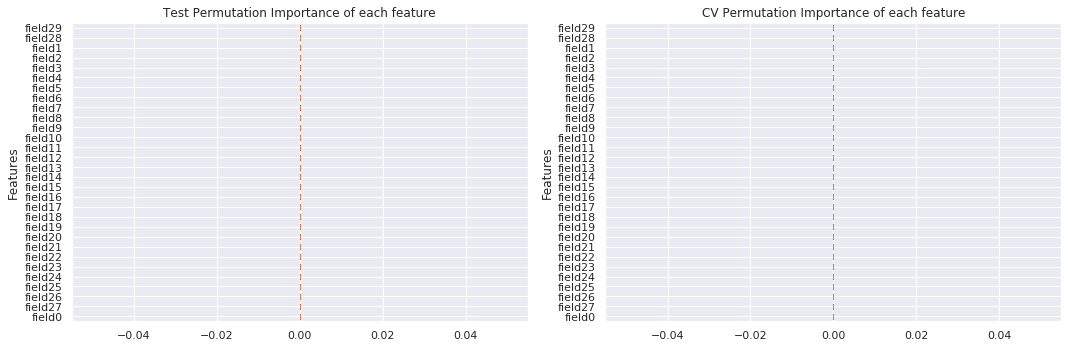

0
[0]	validation_0-logloss:2.91506	validation_0-auc:0.5
[1]	validation_0-logloss:1.73227	validation_0-auc:0.5
[2]	validation_0-logloss:1.42119	validation_0-auc:0.5
[3]	validation_0-logloss:1.21309	validation_0-auc:0.5


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-logloss:1.05783	validation_0-auc:0.5
[5]	validation_0-logloss:0.935346	validation_0-auc:0.5
[6]	validation_0-logloss:0.835328	validation_0-auc:0.5
[7]	validation_0-logloss:0.751703	validation_0-auc:0.5
[8]	validation_0-logloss:0.680574	validation_0-auc:0.5
[9]	validation_0-logloss:0.619283	validation_0-auc:0.5
[10]	validation_0-logloss:0.565928	validation_0-auc:0.5
[11]	validation_0-logloss:0.519102	validation_0-auc:0.5
[12]	validation_0-logloss:0.477733	validation_0-auc:0.5
[13]	validation_0-logloss:0.440983	validation_0-auc:0.5
[14]	validation_0-logloss:0.408188	validation_0-auc:0.5
[15]	validation_0-logloss:0.37881	validation_0-auc:0.5
[16]	validation_0-logloss:0.352408	validation_0-auc:0.5
[17]	validation_0-logloss:0.328614	validation_0-auc:0.5
[18]	validation_0-logloss:0.307121	validation_0-auc:0.5
[19]	validation_0-logloss:0.287669	validation_0-auc:0.5
[20]	validation_0-logloss:0.270035	validation_0-auc:0.5
[21]	validation_0-logloss:0.254027	validation_0-auc:0.5


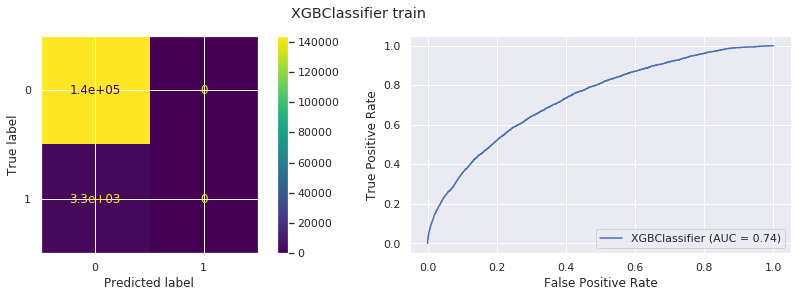

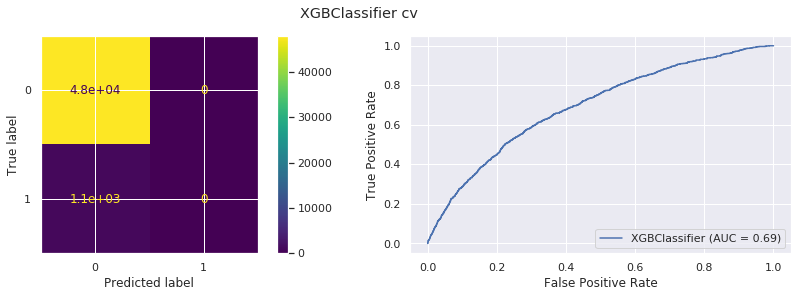

In [24]:
X, y = prepare_data( df_train )

X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)

model = XGBClassifier(**get_best_params()).fit(X, y.values.ravel())

plot_permutation_importance(model, X_train, y_train, X_cv, y_cv)

estimate(X, y, model);

In [40]:
X.columns[sorted_idx]

Index(['field5', 'field19', 'field7', 'field2', 'field15', 'field8', 'field20',
       'field0', 'field16', 'field4', 'field9', 'field17', 'field18', 'field1',
       'field14', 'field11', 'field12', 'field6', 'field21', 'field13',
       'field3', 'field10'],
      dtype='object')

In [0]:
'''
estimators = 236
  return {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 0.6,
 'missing': None,
 'n_estimators': estimators,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': RS,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0.04082, # 12.166, counts[0]/counts[1]
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'verbosity': 0,
 # If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping
 'eval_metric': ['logloss', 'auc'], #'RMSE', 'logloss', 'MAP', 'NDCG', 'AUC', 'ams@0'
 'tree_method': 'gpu_hist',
 'updater': 'grow_gpu_hist',
 'disable_default_eval_metric': 1,
 }
 '''

## RandomizedSearchCV

In [69]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
import sklearn.ensemble

X, y = prepare_data(df_train)

params = {'base_score': sp_randFloat(),
 'colsample_bylevel': sp_randFloat(),
 'colsample_bynode': sp_randFloat(),
 'colsample_bytree': sp_randFloat(),
 'gamma': sp_randInt(0, 100),
 'learning_rate': sp_randFloat(),
 'max_delta_step': sp_randInt(0, 100),
 'max_depth': sp_randInt(2, 10),
 'min_child_weight': sp_randFloat(),
 'n_estimators': sp_randInt(10, 500),
 'reg_alpha': sp_randFloat(),
 'reg_lambda': sp_randFloat(),
 'scale_pos_weight': sp_randFloat(),
 'subsample': sp_randFloat(),
 }

clf = XGBClassifier(**get_best_params())

rs = RandomizedSearchCV(clf, 
                        param_distributions=params, 
                        cv=2, 
                        verbose=1, 
                        n_iter=1000, 
                        scoring='roc_auc',
                        n_jobs=-1)
rs.fit(X, y.values.ravel())
print( rs.best_params_ )
print( rs.best_score_ )
#{'base_score': 0.6644410991187997, 'colsample_bylevel': 0.6059678409651669, 'colsample_bynode': 0.17400982470452497, 'colsample_bytree': 0.6647085043362304, 'gamma': 0.01605629494332772, 'learning_rate': 0.09143541671068811, 'max_delta_step': 0.9405103527865268, 'max_depth': 9, 'min_child_weight': 0.23677205024963843, 'n_estimators': 116, 'n_jobs': -1, 'random_state': 77, 'reg_alpha': 0.983017349002685, 'reg_lambda': 0.7338821091963531, 'scale_pos_weight': 0.1314841497459578, 'seed': 7, 'subsample': 0.610130474493417}
#{'base_score': 0.0006763272285300603, 'colsample_bylevel': 0.9131040645300111, 'colsample_bynode': 0.6217260824900458, 'colsample_bytree': 0.498105896239323, 'gamma': 0.7503808382193502, 'learning_rate': 0.5233450726284934, 'max_delta_step': 0.2189376337324893, 'max_depth': 8, 'min_child_weight': 0.9084424403935606, 'n_estimators': 177, 'n_jobs': -1, 'random_state': 77, 'reg_alpha': 0.8494551200058984, 'reg_lambda': 0.8606428319131949, 'scale_pos_weight': 0.11685893701548733, 'seed': 6, 'subsample': 0.6828797818811899}
#{'base_score': 0.9883241431311958, 'colsample_bylevel': 0.8954745282201794, 'colsample_bynode': 0.9053728787963939, 'colsample_bytree': 0.37737648074076036, 'gamma': 51, 'learning_rate': 0.06869149756603576, 'max_delta_step': 22, 'max_depth': 4, 'min_child_weight': 0.8940873051252118, 'n_estimators': 298, 'reg_alpha': 0.2901487558842103, 'reg_lambda': 0.7240220329478356, 'scale_pos_weight': 0.11997115325466545, 'subsample': 0.699092108437742}
0.6827676748753305

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 87.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 98.3min finished


{'base_score': 0.9883241431311958, 'colsample_bylevel': 0.8954745282201794, 'colsample_bynode': 0.9053728787963939, 'colsample_bytree': 0.37737648074076036, 'gamma': 51, 'learning_rate': 0.06869149756603576, 'max_delta_step': 22, 'max_depth': 4, 'min_child_weight': 0.8940873051252118, 'n_estimators': 298, 'reg_alpha': 0.2901487558842103, 'reg_lambda': 0.7240220329478356, 'scale_pos_weight': 0.11997115325466545, 'subsample': 0.699092108437742}
0.6827676748753305


0.6772912978785195

## Submit the result

In [119]:
model.best_ntree_limit

AttributeError: ignored

In [120]:
X_test, _ = prepare_data( df_test )

if hasattr(model, 'best_ntree_limit'):
  print(0)
  proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
else:
  print(1)
  proba = model.predict_proba(X_test)

pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index).to_csv('sub1.csv')
pd.DataFrame(model.predict(X_test), columns=['proba'], index=X_test.index).sum()

1


proba    0
dtype: int64

In [121]:
!zip sub1.csv.zip sub1.csv

updating: sub1.csv (deflated 64%)


In [0]:
!pip3 install -q eli5
import eli5
from eli5.sklearn import PermutationImportance

In [107]:
!pip3 install -q catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 63.6MB 124kB/s 


In [0]:
!pip install -q shap

In [0]:
!pip install -q scikit-plot
